# Transfer Learning

Transfer learning es una técnica muy poderosa para aprovechar los parámetros aprendidos de modelos entrenados en conjuntos de datos similares.

Es muy útil cuando no tenemos suficiente data.

Puede incrementar dramáticamente nuestro desempeño, a la vez que reduce el tiempo de entrenamiento.

## Cargando el Conjunto de Datos de Perros

Usaremos una red pre-entrenada en Imagenet para clasificar diferentes razas de perros. Empecemos por cargar la data en memoria. Los datos pueden descargarse [aquí](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). Colócalos dentro de la carpeta `dog_images`.

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

DATASET_SOURCE = 'dog_images'
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    
    return dog_files, dog_targets

# Load train, test and validation datasets.
train_files, train_targets = load_dataset(f'{DATASET_SOURCE}/train')
valid_files, valid_targets = load_dataset(f'{DATASET_SOURCE}/valid')
test_files, test_targets = load_dataset(f'{DATASET_SOURCE}/test')

# Load ordered list of dog names.
dog_names = [item[25:-1] for item in glob(f'{DATASET_SOURCE}/train/*/')]

print(f'There are {len(dog_names)} dog categories.')
print(f'There are {len(train_files) + len(valid_files) + len(test_files)} dog images.')
print(f'There are {len(train_files)} training dog images.')
print(f'There are {len(valid_files)} validation dog images.')
print(f'There are {len(test_files)} test dog images.')

Using TensorFlow backend.


There are 133 dog categories.
There are 8351 dog images.
There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


## Visualizando Una Muestra de las Imágenes de Entrenamiento

Familiaricémonos con los datos.

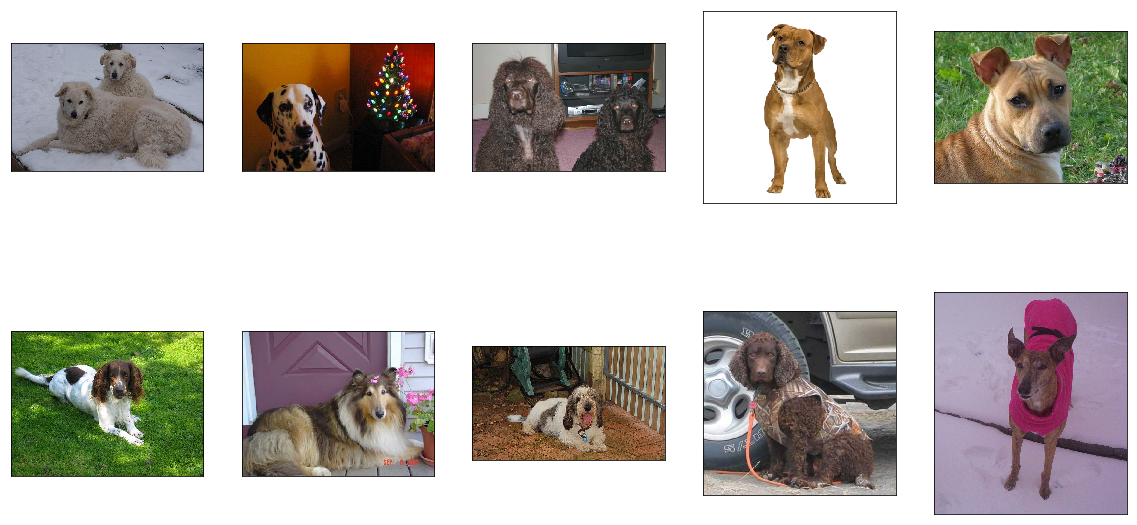

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_image(image_path, ax):
    image = cv2.imread(image_path)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
SAMPLE_SIZE = 10
figure = plt.figure(figsize=(20, 10))
for index in range(SAMPLE_SIZE):
    ax = figure.add_subplot(2, 5, index + 1, xticks=[], yticks=[])
    visualize_image(train_files[index], ax)

## Obteniendo los _Features_ Cuello de Botella de VGG-16

Los _bottleneck features_ son la representación abstracta de las imágenes luego de haber pasado por las capas inmutables (congeladas) de la red neuronal (en este caso, VGG-16). Descarga los _features_ pre-calculados [aquí](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz), y colócalos en la carpeta `bottleneck_features/`.

In [3]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')

train_vgg16 = bottleneck_features['train']
valid_vgg16 = bottleneck_features['valid']
test_vgg16 = bottleneck_features['test']

## Definiendo los Modelos

Definamos un par de arquitectruas diferentes para ver cómo se desempeñan.

In [4]:
from keras.layers import Dense, Flatten
from keras.models import Sequential

first_model = Sequential()
first_model.add(Flatten(input_shape=(7, 7, 512)))
first_model.add(Dense(133, activation='softmax'))

first_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
first_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               3336837   
Total params: 3,336,837
Trainable params: 3,336,837
Non-trainable params: 0
_________________________________________________________________


In [5]:
from keras.layers import GlobalAveragePooling2D

second_model = Sequential()
second_model.add(GlobalAveragePooling2D(input_shape=(7, 7, 512)))
second_model.add(Dense(133, activation='softmax'))

second_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
second_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


## Entrenando los Modelos

In [6]:
from keras.callbacks import ModelCheckpoint

def train_model(model, saved_model_output, batch_size, epochs, plot_history=True):
    checkpointer = ModelCheckpoint(filepath=saved_model_output, save_best_only=True)
    
    history = model.fit(train_vgg16, 
                     train_targets, 
                     batch_size=batch_size, 
                     epochs=epochs, validation_data=(valid_vgg16, valid_targets), 
                     callbacks=[checkpointer], 
                     shuffle=True)
    
    if plot_history:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 416us/step - loss: 15.5246 - acc: 0.0334 - val_loss: 15.2670 - val_acc: 0.0503
Epoch 2/20
6680/6680 [==============================] - 2s 353us/step - loss: 15.1054 - acc: 0.0617 - val_loss: 15.1686 - val_acc: 0.0575
Epoch 3/20
6680/6680 [==============================] - 2s 351us/step - loss: 15.0170 - acc: 0.0668 - val_loss: 15.0538 - val_acc: 0.0647
Epoch 4/20
6680/6680 [==============================] - 2s 352us/step - loss: 14.9006 - acc: 0.0743 - val_loss: 14.8879 - val_acc: 0.0731
Epoch 5/20
6680/6680 [==============================] - 2s 332us/step - loss: 14.8067 - acc: 0.0808 - val_loss: 14.9345 - val_acc: 0.0731
Epoch 6/20
6680/6680 [==============================] - 2s 344us/step - loss: 14.8131 - acc: 0.0804 - val_loss: 14.9321 - val_acc: 0.0719
Epoch 7/20
6680/6680 [==============================] - 2s 344us/step - loss: 14.7965 - acc: 0.0811 - val_loss: 15.0007 - val

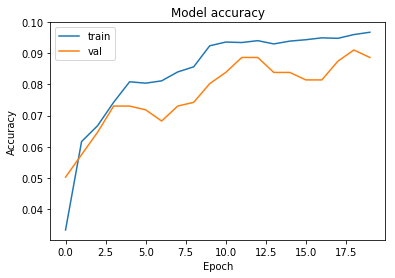

In [7]:
FLAT_BEST_MODEL_OUTPUT = 'saved_models/flat.dog.best.hdf5'

EPOCHS = 20
BATCH_SIZE = 256
train_model(first_model, FLAT_BEST_MODEL_OUTPUT, BATCH_SIZE, EPOCHS)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s 111us/step - loss: 13.2965 - acc: 0.0413 - val_loss: 11.5424 - val_acc: 0.1006
Epoch 2/20
6680/6680 [==============================] - 1s 94us/step - loss: 9.9864 - acc: 0.1606 - val_loss: 9.0495 - val_acc: 0.2012
Epoch 3/20
6680/6680 [==============================] - 1s 98us/step - loss: 7.7457 - acc: 0.3039 - val_loss: 7.5931 - val_acc: 0.3186
Epoch 4/20
6680/6680 [==============================] - 1s 87us/step - loss: 6.6267 - acc: 0.4198 - val_loss: 6.9683 - val_acc: 0.3701
Epoch 5/20
6680/6680 [==============================] - 1s 88us/step - loss: 5.9212 - acc: 0.4942 - val_loss: 6.5165 - val_acc: 0.4120
Epoch 6/20
6680/6680 [==============================] - 1s 93us/step - loss: 5.5370 - acc: 0.5493 - val_loss: 6.3504 - val_acc: 0.4287
Epoch 7/20
6680/6680 [==============================] - 1s 93us/step - loss: 5.3527 - acc: 0.5831 - val_loss: 6.2253 - val_acc: 0.4479
Epoch

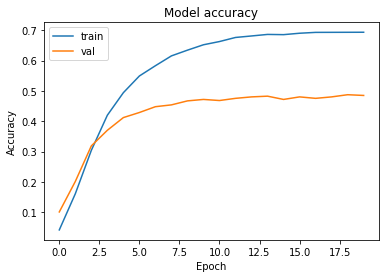

In [8]:
GLOBAL_POOLING_BEST_MODEL_OUTPUT = 'saved_models/gp.dog.best.hdf5'

EPOCHS = 20
BATCH_SIZE = 256
train_model(second_model, GLOBAL_POOLING_BEST_MODEL_OUTPUT, BATCH_SIZE, EPOCHS)

## Cargando los Mejores Modelos

Carguemos los mejores modelos resultantes del proceso de entrenamiento, y veamos cómo se desempeñan con data nueva.

In [9]:
first_model.load_weights(FLAT_BEST_MODEL_OUTPUT)
second_model.load_weights(GLOBAL_POOLING_BEST_MODEL_OUTPUT)

In [10]:
def get_test_accuracy(model):
    vgg16_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0)))
                         for feature in test_vgg16]
    
    test_set_size = len(vgg16_predictions)
    return np.sum(np.array(vgg16_predictions) == 
                  np.argmax(test_targets, axis=1)) / test_set_size

flat_model_accuracy = get_test_accuracy(first_model)
print(f'Test accuracy for flat model: {100 * flat_model_accuracy}%')

global_pooling_model_accuracy = get_test_accuracy(second_model)
print(f'Test accuracy for global pooling model: {100 * global_pooling_model_accuracy}%')

Test accuracy for flat model: 9.330143540669857%
Test accuracy for global pooling model: 50.23923444976076%
